# Bootstrapping confidence intervals for per-feature accuracy metrics

With many thanks to Luke Tudge who provided most of this script on the basis of my attempt in R (see TaggerTestResults.Rmd), which proved too slow to run at scale on a decent amount of bootstrap samples.

In [2]:
import time

import numpy
import pandas
import plotnine
import scipy
import sklearn

%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

## Data

The data on the performance of the MFTE is taken from saved as `MFTE_Evaluation_BNC2014_Results_merged.csv` and is produced by the RMarkdown file `TaggerTestResults.Rmd`.

*(Note that one of the possible tags is `NULL`, which the `pandas` package will by default interpret as a missing value, so we need to set the additional argument `keep_default_na` to prevent this when importing the data.)*

In [3]:
data = pandas.read_csv('/Users/Elen/Documents/PhD/MSc_Thesis/BNC2014Baby/MFTE_Evaluation_BNC2014_Results_merged.csv', keep_default_na=False)

data

,Unnamed: 0,FileID,Corpus,Register,Output,Token,Tag,TagGold,Evaluation
0,1,BNCBAcbH_m1,BNC2014,academic,According_VBG,According,VBG,VBG,True
1,2,BNCBAcbH_m1,BNC2014,academic,to_IN,to,IN,IN,True
2,3,BNCBAcbH_m1,BNC2014,academic,Braestrup_NN,Braestrup,NN,NN,True
3,4,BNCBAcbH_m1,BNC2014,academic,",_,",",",",",",",True
4,5,BNCBAcbH_m1,BNC2014,academic,journalists_NN,journalists,NN,NN,True
...,...,...,...,...,...,...,...,...,...
31261,31262,SZXQ,BNC2014,spoken,'s_VPRTCONTBEMA,'s,BEMA,BEMA,True
31262,31263,SZXQ,BNC2014,spoken,'d_MDWOCONTSPLIT,'d,SPLIT,SPLIT,True
31263,31264,SZXQ,BNC2014,spoken,'s_VPRTCONTBEMA,'s,BEMA,BEMA,True
31264,31265,SZXQ,BNC2014,spoken,'re_VPRTCONTBEMA,'re,BEMA,BEMA,True


Each row is one token in a corpus of texts. The important columns are `Tag`, which is the tag that the system assigned to the token, and `TagGold`, which is the 'true' tag assigned manually by a human reader. The tokens are also grouped into different types by the `Register` column. We may later wish to stratify analyses by register.

Let's check the data types of the columns.

In [4]:
data.dtypes

Unnamed: 0     int64
FileID        object
Corpus        object
Register      object
Output        object
Token         object
Tag           object
TagGold       object
Evaluation      bool
dtype: object

## Reduction

Let's count how many instances of each tag we have.

In [5]:
data['TagGold'].value_counts()

NN        5855
IN        2371
DT        1704
.         1488
JJAT      1214
          ... 
STPR         9
ABLE         8
HGOT         8
PRP          1
USEDTO       1
Name: TagGold, Length: 93, dtype: int64

We have a lot of different tags, and some that only occur once or a few times. We are unlikely to be able to draw any useful conclusions about these rare tags, so let's filter them out. The chosen cut-off point is 40. We also are not interested in the `NULL` and `UNCLEAR` tags.

In [26]:
min_n = 40
exclude_tags = ['NULL', 'UNCLEAR']

data['Count'] = data.groupby('TagGold')['TagGold'].transform(len)
enough_data = data['Count'] >= min_n
valid_tag_gold = ~data['TagGold'].isin(exclude_tags)
valid_tag = ~data['Tag'].isin(exclude_tags)
data_filtered = data[enough_data & valid_tag_gold & valid_tag]

data_filtered['TagGold'].value_counts()

NN      5855
IN      2371
DT      1704
.       1488
JJAT    1214
        ... 
WHQU      46
MDCO      44
YNQU      42
THRC      40
HST       40
Name: TagGold, Length: 75, dtype: int64

We now also have a more manageable number of tags.

## Plot

We would like to know which tags the tagging system tended to classify correctly and incorrectly, and what sort of errors it made. Let's try to visualize this with a confusion matrix.

An initial wrangling step is to unify the order of categories in the two tag columns.

In [21]:
tags_remaining = set.union(set(data_filtered['TagGold']), set(data_filtered['Tag']))

data_filtered['TagGold'] = pandas.Categorical(data_filtered['TagGold'], categories=tags_remaining)
data_filtered['Tag'] = pandas.Categorical(data_filtered['Tag'], categories=tags_remaining)

/Applications/anaconda3/envs/miniconda37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda3/envs/miniconda37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now we can make the plot.

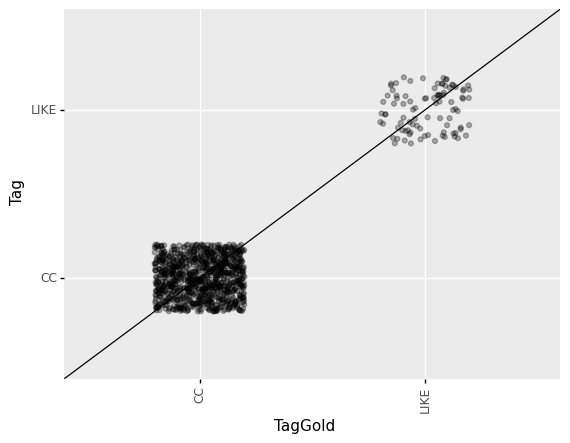

In [9]:
fig1 = (plotnine.ggplot(data_filtered, plotnine.aes(x='TagGold', y='Tag'))
 + plotnine.theme(axis_text_x=plotnine.element_text(rotation=90))
 + plotnine.scales.scale_x_discrete(drop=False)
 + plotnine.geom_abline(slope=1, intercept=0)
 + plotnine.geom_jitter(width=0.2, height=0.2, alpha=0.3))

print(fig1)

## Metrics

For each tag, three accuracy metrics will be calculated: precision, recall and F1 score.

In [22]:
tags = data_filtered['TagGold'].unique()

precision, recall, f1, n = sklearn.metrics.precision_recall_fscore_support(
 data['TagGold'],
 data['Tag'],
 labels=tags
)

results = pandas.DataFrame({
 'tag': tags,
 'precision': precision,
 'recall': recall,
 'f1': f1,
 'n': n
})

results

,tag,precision,recall,f1,n
0,CC,0.995996,0.991036,0.99351,1004
1,WHQU,0.760870,0.760870,0.76087,46


## Bootstrapping

We would also like some idea of the uncertainty in these estimates of the tagger's performance should we apply it to a new sample of texts. For this, we can bootstrap a confidence interval for each of the metrics above.

In [23]:
results = results.melt(id_vars=['tag', 'n'], var_name='metric')
results['lower'] = numpy.nan
results['upper'] = numpy.nan
results['valid'] = False

results

,tag,n,metric,value,lower,upper,valid
0,CC,1004,precision,0.995996,NaN,NaN,False
1,WHQU,46,precision,0.760870,NaN,NaN,False
2,CC,1004,recall,0.991036,NaN,NaN,False
3,WHQU,46,recall,0.760870,NaN,NaN,False
4,CC,1004,f1,0.993510,NaN,NaN,False
5,WHQU,46,f1,0.760870,NaN,NaN,False


Now we want to go through our results and run the bootstrapping for each metric. This is fairly complicated, and time-consuming. We can also save some computation time by reducing the data to the tokens that meet the inclusion criteria we defined above, and by skipping the cases in which the metric value is 1, for which no confidence interval can be defined.

In [24]:
n_resamples = 1000

data_bootstrap = data[data['TagGold'].isin(tags) | data['Tag'].isin(tags)]

for rownum, row in results.iterrows():
    
    print(rownum, ':', row['tag'], row['metric'], '... ', end='')
    start_time = time.time()
    
    if row['value'] == 1.0:
        print('skipping')
        continue
    
    if row['metric'] == 'precision':
        func = sklearn.metrics.precision_score
    elif row['metric'] == 'recall':
        func = sklearn.metrics.recall_score
    else:
        func = sklearn.metrics.f1_score
        
    def metric(y_true, y_pred):
        return func(y_true, y_pred, labels=[row['tag']], average=None)[0]

    boot = scipy.stats.bootstrap(
     (data_bootstrap['TagGold'], data_bootstrap['Tag']),
     metric,
     vectorized=False,
     paired=True,
     n_resamples=n_resamples,
     method='percentile',
     random_state=0
    )
    
    print('done', int(time.time() - start_time), 's')
    
    results.loc[rownum, 'lower'] = boot.confidence_interval.low
    results.loc[rownum, 'upper'] = boot.confidence_interval.high
    results.loc[rownum, 'valid'] = True

0 : CC precision ... done 7 s
1 : WHQU precision ... done 8 s
2 : CC recall ... done 12 s
3 : WHQU recall ... done 8 s
4 : CC f1 ... done 7 s
5 : WHQU f1 ... done 7 s


Let's take a look at the results, and save them to file.

In [25]:
results.to_csv('MFTE_Evaluation_BNC2014_CIs_WHQU_CC.csv', index=False)

results

,tag,n,metric,value,lower,upper,valid
0,CC,1004,precision,0.995996,0.991097,0.999008,True
1,WHQU,46,precision,0.760870,0.630435,0.875000,True
2,CC,1004,recall,0.991036,0.985060,0.996040,True
3,WHQU,46,recall,0.760870,0.634126,0.880952,True
4,CC,1004,f1,0.993510,0.989960,0.996991,True
5,WHQU,46,f1,0.760870,0.659091,0.845381,True


### Plot

Now we would like to see the intervals.

In [ ]:
fig2 = (plotnine.ggplot(results, plotnine.aes(x='tag', y='value'))
 + plotnine.theme(axis_text_x=plotnine.element_text(rotation=90))
 + plotnine.geoms.geom_segment(plotnine.aes(xend='tag', y='lower', yend='upper'))
 + plotnine.geom_point(plotnine.aes(color='valid'), size=0.5)
 + plotnine.facets.facet_wrap(facets=['metric'], ncol=1))

print(fig2)